In [ ]:
from skimage.measure import block_reduce
import numpy as np

import logging
import matplotlib.gridspec as gridspec
from utils import logging as lg
lg.set_logging(logging.ERROR)
from model import provider, heatmap_evaluation
import matplotlib.pyplot as plt

from notebook_utils import plot 
import config

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [ ]:
from utils import data_provider

In [ ]:
dataset_loader = data_provider.DatasetLoader(data_dir='../data')

## Compare_explaination_for_models

In [33]:
def compare_explaination_for_models(method='lrp_deep_taylor', models=['shallow', 'deep'], seq=7, dataset='mnist', 
                                    data_idx=[], n=12, showTitle=False, cell_height=1, cell_width=3, plot_data=False):
    dataset = dataset_loader.load(dataset)
    if len(data_idx) > 0:
        x, y = dataset.test2d.x[data_idx, :, :], dataset.test2d.y[data_idx, :]
    else:
        x, y = dataset.get_samples_for_vis(n=n)
        
    targets = np.argmax(y, axis=1)
    if plot_data:
        models = [None]+models
        
    total_models = len(models)

    
    fig = plt.figure(figsize=(cell_width*x.shape[0], cell_height*len(models)))


    outer = gridspec.GridSpec(total_models, 1)

    pred_heatmaps = dict()
    actual_models = list(filter(lambda x: x, models))
    model_info = dict()
    for model in actual_models:
        model_obj = provider.load(model)
        pred_heatmaps[model] = getattr(model_obj, 'rel_%s' % method)(x, y)
        model_info[model] = model_obj._
    count = 1
    
    for i in range(total_models):

        model = models[i]
        inner = gridspec.GridSpecFromSubplotSpec(1, x.shape[0], subplot_spec=outer[i], wspace=0.1, hspace=0.05)        

        for j in range(x.shape[0]):
            ax = plt.Subplot(fig, inner[j])

            if model is not None:
                heatmap = pred_heatmaps[model][1][j, :, :]

                heatmap = heatmap / (np.abs(heatmap).max() + 1e-10)


                heatmap = plot.make_rgb_heatmap(heatmap)
                title = '%s : %s' % (method, model)

                pred_idx = pred_heatmaps[model][0][j]

                cmap = None
                alpha= 0.2 if pred_idx != targets[j] else 1
        
                suptitle = '%s\n(acc=%.4f)' % (model, model_info[model].accuracy)
            else:
                heatmap = x[j, :]
                pred_idx = pred_heatmaps[actual_models[0]][0][j]

                cmap = 'gist_gray'
                title = '%s(%d)' % (dataset.get_text_label(targets[j]), targets[j])
#                 plt.title(title)
                alpha = 1
                suptitle = '%s' % method

            ax.imshow(heatmap, cmap=cmap, alpha=alpha)
            ax.set_xticks([])
            ax.set_yticks([])
#             ax.set_axis_off()

            fig.add_subplot(ax)

            count = count + 1
        ax_outer = plt.Subplot(fig, outer[i])

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        ax_outer.set_axis_off()
        if showTitle or (plot_data and i > 1):
            ax_outer.set_title(suptitle)

    plt.show()
    
def compare_explaination_for_dataset(methods, models, dataset, seq, **kargs):
    
    for m in methods:
        compare_explaination_for_models(m,
                                        seq=seq,
                                        dataset=dataset,
                                        models=[ '../final-models/%s-%s-seq-%d' % (m, dataset, seq) for m in models],
                                        **kargs
                                   )

In [52]:
data_indices = {
    'exp2': {
        'mnist': [22, 5069, 99],
        'fmnist': [7639, 863, 559],
    },
    'exp2_failed_cases': {
        'mnist': [9407, 913, 1898],
        'susprecious_mnist': [0, 3, 4, 5, 7],
        'fmnist': [3696, 2862, 7206]
    }
}

methods = ['sensitivity', 'guided_backprop', 'lrp_deep_taylor', 'lrp_alpha1_5_beta_5']

## MNIST

[4601, 2665, 6337, 189, 1183, 1433, 1468, 279, 3720, 2526, 2459, 2267]


/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


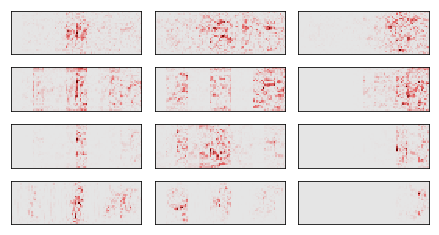

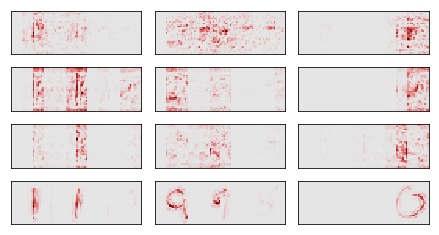

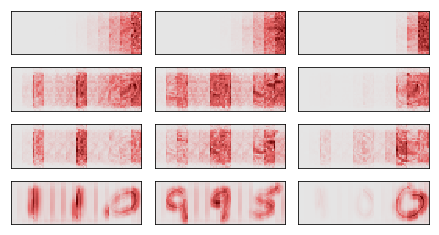

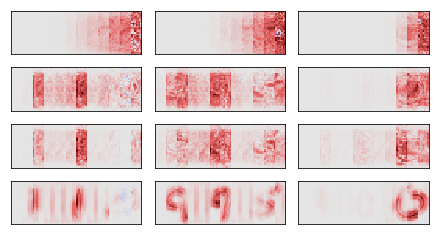

In [37]:
rd = list(np.random.choice(10000, 12))
selected = [22, 5069, 99, 334, 5004] + rd
print(rd)

compare_explaination_for_dataset(
        methods=methods,
        models=[
            'shallow', 
            'deep',
            'deep_v2',
            'convdeep',
        ],
        dataset='mnist-3-digits-maj', seq=12,
        #                                      data_idx=rd,
        data_idx=data_indices['exp2_failed_cases']['mnist'],  
        cell_height=1, cell_width = 2.5, plot_data=False,
        showTitle=False
)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


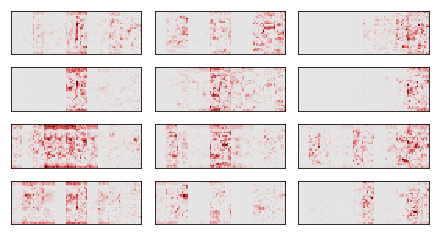

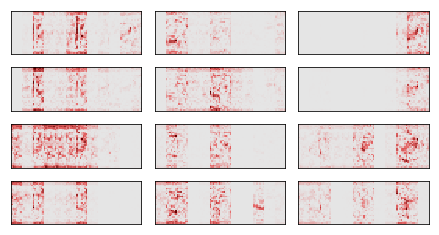

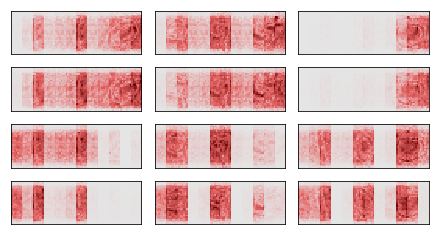

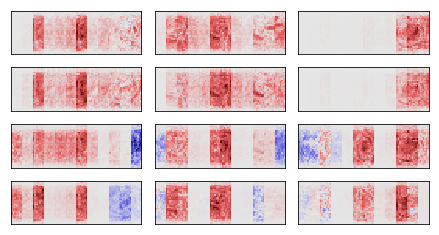

In [50]:
compare_explaination_for_dataset(
        methods=methods,
        models=[
            'deep', 'deep_persisted_dropout', 'rlstm', 'rlstm_persisted_dropout'
        ],
        dataset='mnist-3-digits-maj', seq=12,
        data_idx=data_indices['exp2_failed_cases']['mnist'],  
        cell_height=1, cell_width = 2.5, plot_data=False,
        showTitle=False
)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


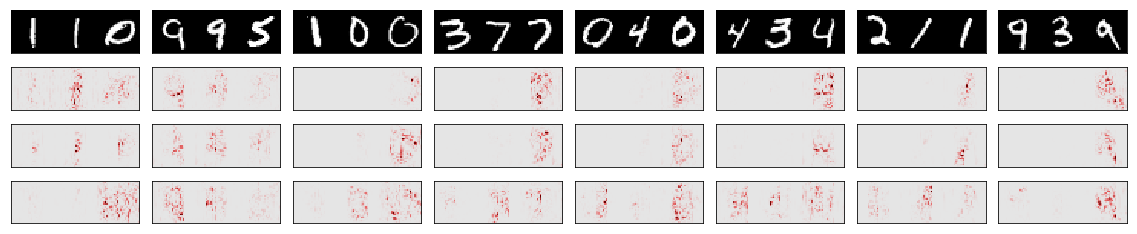

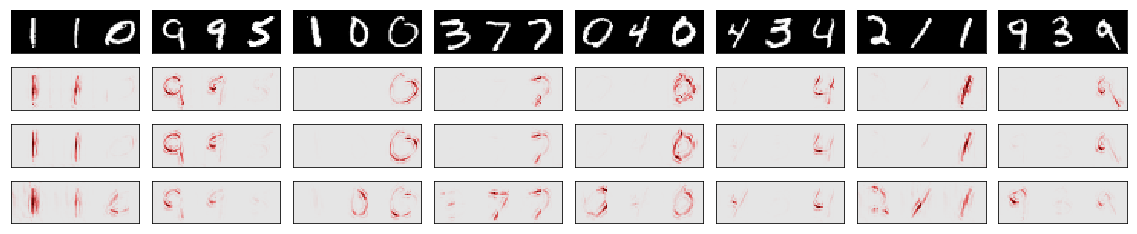

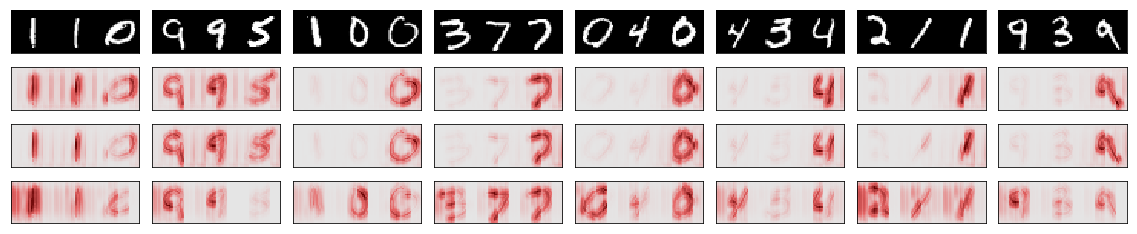

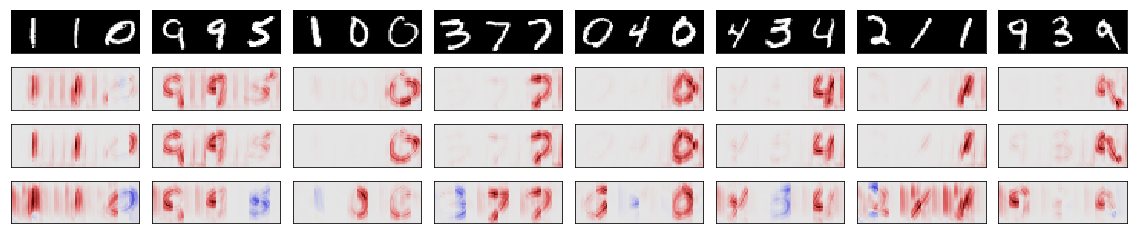

In [54]:
compare_explaination_for_dataset(
        methods=methods,
        models=[
            'convdeep', 'convdeep_transcribe', 'convrlstm_persisted_dropout',
        ],
        dataset='mnist-3-digits-maj', seq=12,
        data_idx=data_indices['exp2_failed_cases']['mnist'] + data_indices['exp2_failed_cases']['susprecious_mnist'],  
        cell_height=1, cell_width = 2.5, plot_data=True,
        showTitle=False
)

## FMNIST

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


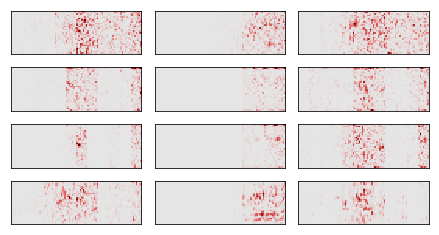

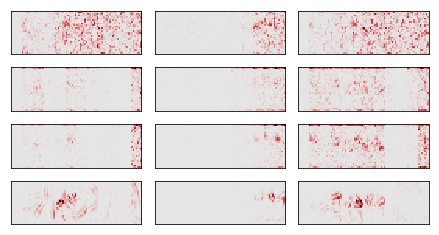

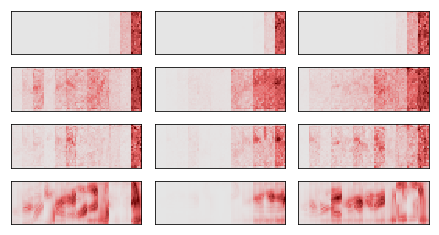

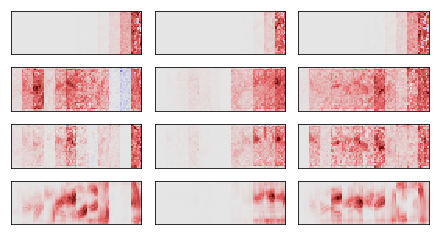

In [45]:
compare_explaination_for_dataset(
        methods=methods,
        models=[
            'shallow', 
            'deep',
            'deep_v2',
            'convdeep',
        ],
        dataset='fashion-mnist-3-items-maj', seq=12,
        data_idx=data_indices['exp2_failed_cases']['fmnist'],  
        cell_height=1, cell_width = 2.5, plot_data=False,
        showTitle=False
)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


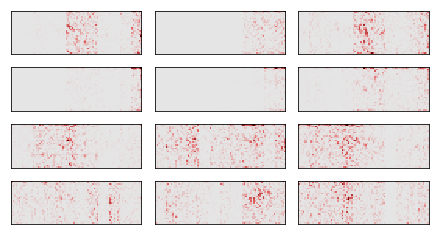

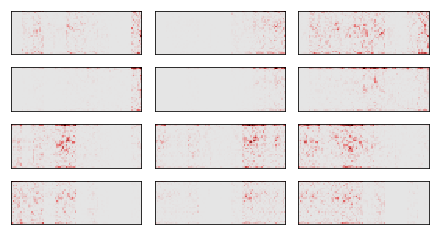

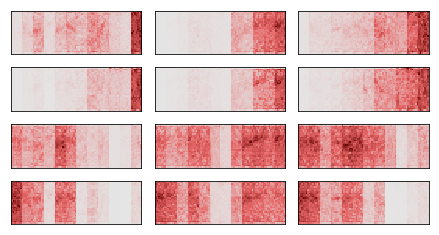

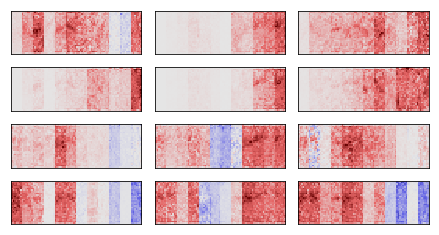

In [46]:
compare_explaination_for_dataset(
        methods=methods,
        models=[
            'deep', 'deep_persisted_dropout', 'rlstm', 'rlstm_persisted_dropout'
        ],
        dataset='fashion-mnist-3-items-maj', seq=12,
        data_idx=data_indices['exp2_failed_cases']['fmnist'],  
        cell_height=1, cell_width = 2.5, plot_data=False,
        showTitle=False
)

/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


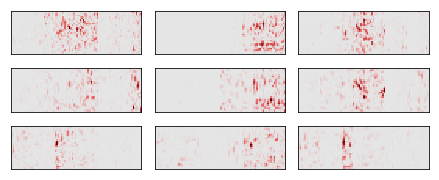

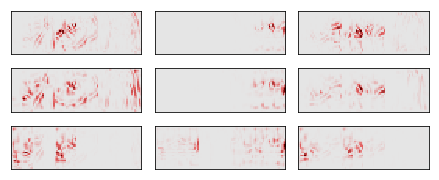

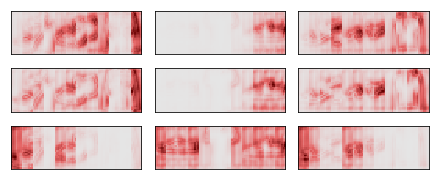

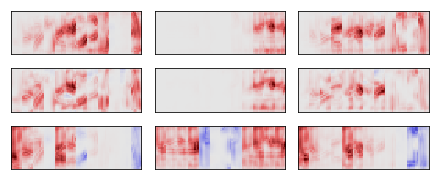

In [49]:
compare_explaination_for_dataset(
        methods=methods,
        models=[
            'convdeep', 'convdeep_transcribe', 'convrlstm_persisted_dropout',
        ],
        dataset='fashion-mnist-3-items-maj', seq=12,
        data_idx=data_indices['exp2_failed_cases']['fmnist'],  
        cell_height=1, cell_width = 2.5, plot_data=False,
        showTitle=False
)

In [ ]:
rd = list(np.random.choice(10000, 12))
selected = [22, 5069, 99, 334, 5004] + rd
print(rd)
for med in ['sensitivity', 'guided_backprop', 'lrp_deep_taylor', 'lrp_alpha1_5_beta_5']:
    compare_explaination_for_dataset(med, models=['deep', 'deep_persisted_dropout', 'rlstm', 'rlstm_persisted_dropout'],
                                     dataset='mnist-3-digits-maj', seq=12,
                                     data_idx=selected[:3], cell_height=1, cell_width = 2.5, plot_data=False, showTitle=True)

[7948 4645 2290 1792 1516 1759   49 7812 1971 4959 2308  319]


/Users/heytitle/projects/heatmapping-tutorial/src/model/components/layer.py:34: RuntimeWarning: divide by zero encountered in log
  self.b = tf.Variable(tf.ones(dims[-1]) * float(np.log(np.exp(DEFAULT_BIAS_VALUE)-1)), name=b_name)


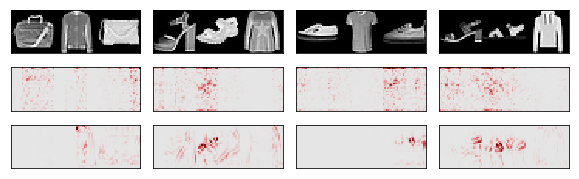

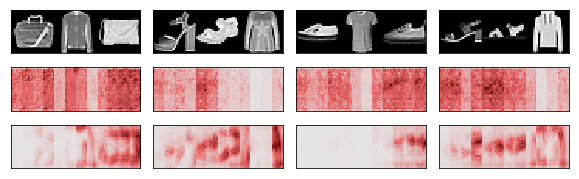

In [31]:
dd = np.random.choice(10000, 12)

selected = [7639, 863, 559, 1752, 7954, 9238] + list(dd)
print(dd)
for med in ['guided_backprop', 'lrp_deep_taylor']:
    compare_explaination_for_dataset(med, models=['rlstm', 'convdeep'],
                                     dataset='fashion-mnist-3-items-maj', seq=12,
                                     data_idx=data_indices['exp2_failed_cases']['fmnist'],
#                                      data_idx=dd, 
                                     cell_height=1, cell_width = 2.5, plot_data=True, showTitle=True)

In [ ]:
dd = np.random.choice(10000, 12)

selected = [7639, 863, 559, 1752, 7954, 9238] + list(dd)
print(dd)
for med in ['sensitivity', 'guided_backprop', 'lrp_deep_taylor', 'lrp_alpha1_5_beta_5']:
    compare_explaination_for_dataset(med, models=['shallow', 'deep', 'convdeep', 'rlstm'],
                                     dataset='fashion-mnist-3-items-maj', seq=12,
                                     data_idx=selected[:3], cell_height=1, cell_width = 2.5, plot_data=False, showTitle=True)

In [ ]:
for m in ['guided_backprop', 'lrp_deep_taylor']:
    compare_explaination_for_models(m,
        seq=1,
        dataset='fashion-mnist',
        models=[
#             '../experiment-results/models-for-exp3/lenet-fashion-mnist-seq-1---2018-03-22--13-13-49', # keep_prob = 1
# #             '../experiment-results/models-for-exp3/lenet-fashion-mnist-seq-1---2018-03-22--13-22-46', # keep_prob = 0.8
#             '../experiment-results/models-for-exp3/lenet-fashion-mnist-seq-1---2018-03-22--13-46-42', # keep_prob = 0.5
            
#             '../experiment-results/models-for-exp3/convdeep-fashion-mnist-seq-1---2018-03-22--14-45-25', # keep prob=1
#             '../experiment-results/models-for-exp3/convdeep-fashion-mnist-seq-1---2018-03-22--14-32-27', # keep_prob = 0.8            
#             '../experiment-results/models-for-exp3/deep-fashion-mnist-seq-1---2018-03-22--14-00-21', # keep_pob = 0.5

            # 50 epochs
#             '../experiment-results/models-for-exp3/convdeep-fashion-mnist-seq-1---2018-03-22--15-13-33', # keep_prob=1
#             '../experiment-results/models-for-exp3/convdeep-fashion-mnist-seq-1---2018-03-22--15-52-29', # keep_prob=0.5
            
            # seq 4
            '../experiment-results/models-for-exp3/convdeep-fashion-mnist-seq-4---2018-03-22--16-10-01',
            '../experiment-results/models-for-exp3/convdeep-fashion-mnist-seq-4---2018-03-22--17-18-13'
        ],
            cell_height=1, cell_width = 1, plot_data=True, showTitle=True, n=6, data_idx=[5, 20, 3005, 2405, 777, 90]
       )

In [ ]:
for med in ['sensitivity', 'guided_backprop', 'lrp_deep_taylor']:
    compare_explaination_for_dataset(med, models=['shallow', 'deep'], dataset='fashion-mnist', seq=7, n=4)

In [ ]:
rd = list(np.random.choice(10000, 12))
selected = [22, 5069, 99, 334, 5004] + rd
print(rd)
for med in ['sensitivity']:
    compare_explaination_for_dataset(med, models=['shallow', 'deep', 'rlstm'],
                                     dataset='mnist-3-digits-maj', seq=12,
                                     data_idx=selected[:4])

In [ ]:
dd = np.random.choice(10000, 12)

selected = [7639, 863, 559, 1752, 7954, 9238] + list(dd)
print(dd)
for med in ['sensitivity', 'guided_backprop', 'lrp_deep_taylor']:
    compare_explaination_for_dataset(med, models=['deep_v2'],
                                     dataset='fashion-mnist-3-items-maj', seq=12,
                                     data_idx=selected[:4])

In [ ]:
        
compare_explaination_for_models('lrp_deep_taylor',
                                seq=12,
                                dataset='mnist-3-digits-maj',
                                data_idx=[9192,3,4, 5127],
                                models=[
                                    '../final-models/s2_network-mnist-3-digits-maj-seq-12',
                                    '../final-models/s3_network-mnist-3-digits-maj-seq-12',
                                  '../final-models/deep_4l_network-mnist-3-digits-maj-seq-12',
                                    '../final-models/convdeep_4l_network-mnist-3-digits-maj-seq-12',
#                                     '../experiment-results/models-for-paper/convdeep_gated_network-mnist-3-digits-maj-seq-12---2018-02-19--00-31-15'
                                ])

In [ ]:
        
compare_explaination_for_models('lrp_deep_taylor',
                                seq=7,
                                dataset='mnist-7-digits',
                                models=[
                                    '../experiment-results/models-for-paper/convdeep_4l_network-mnist-7-digits-seq-7---2018-02-21--11-31-57'
                                ])

In [ ]:
        
compare_explaination_for_models('guided_backprop',
                                seq=7,
                                dataset='mnist-7-digits',
                                models=[
                                    '../experiment-results/models-for-paper/convdeep_4l_network-mnist-7-digits-seq-7---2018-02-21--11-31-57'
                                ])

In [ ]:
        
compare_explaination_for_models('sensitivity',
                                seq=7,
                                dataset='mnist-7-digits',
                                models=[
                                    '../experiment-results/models-for-paper/convdeep_4l_network-mnist-7-digits-seq-7---2018-02-21--11-31-57'
                                ])

In [ ]:
compare_explaination_for_models('guided_backprop',
                                seq=12,
                                dataset='mnist-3-digits-maj',
#                                 data_idx=m3d_8,
                                models=[
                                    '../final-models/s2_network-mnist-3-digits-maj-seq-12',
                                    '../final-models/s3_network-mnist-3-digits-maj-seq-12',
                                    '../experiment-results/models-for-paper/deep_v21_network-mnist-3-digits-maj-seq-12---2018-02-18--22-32-24',
                                    '../final-models/convdeep_4l_network-mnist-3-digits-maj-seq-12',
                                    '../experiment-results/models-for-paper/convdeep_gated_network-mnist-3-digits-maj-seq-12---2018-02-19--00-31-15'
                                ])

In [ ]:
        
compare_explaination_for_models('lrp_alpha2_beta1',
                                seq=12,
                                dataset='fashion-mnist-3-items-maj',
                                models=[
                                    '../final-models/convdeep_4l_network-fashion-mnist-3-items-maj-seq-12',
                                    '../experiment-results/models-for-paper/convdeep_gated_network-fashion-mnist-3-items-maj-seq-12---2018-02-19--09-39-33'
                                ])

In [ ]:
        
compare_explaination_for_models('guided_backprop',
                                seq=12,
                                dataset='fashion-mnist-3-items-maj',
                                models=[t
                                    '../final-models/convdeep_4l_network-fashion-mnist-3-items-maj-seq-12',
                                    '../experiment-results/models-for-paper/convdeep_gated_network-fashion-mnist-3-items-maj-seq-12---2018-02-19--09-39-33'
                                ])

## Plot Explanation Grid

In [ ]:
def plot_explanation_grid_of_sample(dataset, seq, data_idx, methods=['sensitivity', 'guided_backprop', 'lrp_deep_taylor'],
                                     models=['s2', 's3', 'deep_4l', 'convdeep_4l'], ):
    
    data = dataset_loader.load(dataset)
    x, y = data.test2d.x[data_idx, :, :], data.test2d.y[data_idx, :]
    
    plot_digit(x)
    
    x = x.reshape(1, x.shape[0], x.shape[1])
    y = y.reshape(1,-1)
    
    results = dict()
    
    
    for mod in models:
        model_path = '../final-models/%s_network-%s-seq-%d' % (mod, dataset, seq)
        model_obj = provider.load(model_path)
        model_result = dict()
        for met in methods:
            _, model_result[met] = getattr(model_obj, 'rel_%s' % met)(x, y)
            
        results[mod] = model_result
    fig = plt.figure(figsize=(1.66*len(models), 0.5 * len(methods)))
    outer = gridspec.GridSpec(len(methods), 1)
    
    for i, met in enumerate(methods):
        inner = gridspec.GridSpecFromSubplotSpec(1, len(models),
                                                 subplot_spec=outer[i], wspace=0.1, hspace=0.05)

        method = met

        for j in range(len(models)):
            ax = plt.Subplot(fig, inner[j])
            
#             heatmap = plot.norm_and_make_rgb_heatmap()
            heatmap = np.squeeze(results[models[j]][met])

            heatmap = heatmap / (np.abs(heatmap).max() + 1e-10)
            heatmap = plot.make_rgb_heatmap(heatmap)
            ax.imshow(heatmap)
            ax.set_xticks([])
            ax.set_yticks([])

            fig.add_subplot(ax)

        ax_outer = plt.Subplot(fig, outer[i])

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        fig.add_subplot(ax_outer)

    plt.show()
    

def plot_digit(x):
    plt.imshow(x, cmap='gist_gray')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()
    
plot_explanation_grid_of_sample('mnist-3-digits-maj', 12, 7941)

In [ ]:
plot_explanation_grid_of_sample('mnist-3-digits-maj', 12, 9190)

In [ ]:
plot_explanation_grid_of_sample('fashion-mnist-3-items-maj', 12, 5503)

In [ ]:
plot_explanation_grid_of_sample('fashion-mnist-3-items-maj', 12, 7954)

In [ ]:
for idx in np.random.choice(10000, 50):
    plt.imshow(dataset_loader.load('fashion-mnist-3-items-maj').test2d.x[idx, :, :], cmap='gray')
    plt.title(idx)
    plt.show()
# [1932, 8026, 3845, 3287, 5503, 152, 1875]

In [ ]:

def show_xx(dataset):
    compare_explaination_for_models('lrp_deep_taylor',
                                    seq=12,
                                    dataset=dataset,
                                    data_idx=[9190, 7361, 738, 1159, 5503, 152, 1875],
                                    models=[
                                        '../final-models/s2_network-%s-seq-12' % dataset,
                                        '../final-models/s3_network-%s-seq-12' % dataset,
                                        '../final-models/deep_4l_network-%s-seq-12' % dataset,
                                        '../final-models/convdeep_4l_network-%s-seq-12' % dataset,
                                    ])
show_xx('mnist-3-digits-maj')

In [ ]:
def plot_xx(dataset, seq, data_idx):
    compare_explaination_for_models('lrp_deep_taylor',
                                        seq=seq,
                                        dataset=dataset,
                                        data_idx=data_idx,
                                        models=[
                                            '../final-models/shallow-%s-seq-%d' % (dataset, seq),
                                            '../final-models/deep-%s-seq-%d' % (dataset, seq),
                                        ])
plot_xx('mnist', 7, [4651, 4273, 2655, 4085, 9699])

In [ ]:
plot_xx('fashion-mnist', 7, [1680, 5545, 5205, 6080, 5607])

## Plot samples for a model

In [ ]:
def plot_digits(data, title=""):
    plt.figure(figsize=(80,20))
#     plt.figure(figsize=(1.66*data.shape[0], 0.5))

    for i in range(data.shape[0]):
        plt.subplot(4,16, i+1)
        plt.imshow(data[i,:,:], cmap='gray')
        plt.xticks([])
        plt.yticks([])
    if title:
        plt.suptitle(title)
    plt.show()

In [ ]:
def plot_explanation_grid_of_samples_for_a_model(model, dataset, seq, data_idx=[9192,3,4, 5, 55, 660], 
                                                 methods=['sensitivity', 'guided_backprop', 'lrp_deep_taylor'],
                                                ):
    
    data = dataset_loader.load(dataset)
    x, y = data.test2d.x[data_idx, :, :], data.test2d.y[data_idx, :]
    targets = np.argmax(y, axis=1)
#     plot_digits(x)
    
    results = dict()
    
    
    model_path = '../final-models/%s-%s-seq-%d' % (model, dataset, seq)
    model_obj = provider.load(model_path)
    results = dict()
    for met in methods:
        preds, results[met] = getattr(model_obj, 'rel_%s' % met)(x, y)
            
    fig = plt.figure(figsize=(1.66*x.shape[0], 0.5 * (len(methods)+1)))
    outer = gridspec.GridSpec(len(methods)+1, 1)
    
    for i, met in enumerate([None] + methods):
        inner = gridspec.GridSpecFromSubplotSpec(1, x.shape[0],
                                                 subplot_spec=outer[i], wspace=0.1, hspace=0.05)

        method = met

        for j in range(x.shape[0]):
            ax = plt.Subplot(fig, inner[j])
            
            if i == 0:
                ax.imshow(x[j], cmap='gist_gray')
                ax.set_xticks([])
                ax.set_yticks([])

            else:
                heatmap = np.squeeze(results[met][j])

                heatmap = heatmap / (np.abs(heatmap).max() + 1e-10)
                heatmap = plot.make_rgb_heatmap(heatmap)

                ax.imshow(heatmap, alpha = 0.2 if preds[j] != targets[j] else 1)
                ax.set_xticks([])
                ax.set_yticks([])

            fig.add_subplot(ax)

        ax_outer = plt.Subplot(fig, outer[i])

        ax_outer._frameon = False
        ax_outer.xaxis.set_visible(False)
        ax_outer.yaxis.set_visible(False)
        fig.add_subplot(ax_outer)

    plt.show()
plot_explanation_grid_of_samples_for_a_model('convdeep_4l_network', 'mnist-3-digits-maj', 12, data_idx = [700, 9192,3,4, 5127])

In [ ]:
plot_explanation_grid_of_samples_for_a_model('convdeep_with_mark', 'mnist-3-digits-maj', 12, data_idx = [700, 9192,3,4, 5127])

In [ ]:
plot_explanation_grid_of_samples_for_a_model('convdeep_4l_network', 'fashion-mnist-3-items-maj', 12, data_idx = [5503, 9192,4, 5127, 99])

In [ ]:
plot_explanation_grid_of_samples_for_a_model('convdeep_with_mark', 'fashion-mnist-3-items-maj', 12, data_idx = [5503, 9192,4, 5127, 99])

In [ ]:
plot_explanation_grid_of_samples_for_a_model('s3', 'mnist-3-digits-maj', 12, data_idx = [9192,3,4, 5127])

In [ ]:
plot_explanation_grid_of_samples_for_a_model('deep_with_sparsity', 'mnist-3-digits-maj', 12, data_idx = [9192,3,4, 5127])

In [ ]:
plot_explanation_grid_of_samples_for_a_model('convdeep_4l', 'fashion-mnist-3-items-maj', 12, data_idx = [9192,4, 5127, 99])

In [ ]:
plot_explanation_grid_of_samples_for_a_model('convdeep_4l', 'fashion-mnist-3-items-maj', 12, data_idx = [9192,4, 5127, 99])

In [ ]:
def get_data_idx_for_class(data_name, class_idx, no=50, seed=2):
    np.random.seed(seed)

    data = dataset_loader.load(data_name)
    indices = np.argwhere(np.argmax(data.test2d.y, axis=1) == class_idx).reshape(-1)
    np.random.seed(seed)
    
    return np.random.choice(indices, no)
m3d_8 = get_data_idx_for_class('mnist-3-digits', 8, no=20)

In [ ]:
get_data_idx_for_class('mnist', 1, no=5)

In [ ]:
get_data_idx_for_class('fashion-mnist', 1, no=5)

In [ ]:
def get_data_for_class(data_name, class_idx, no=16, seed=2):
    np.random.seed(seed)

    data = dataset_loader.load(data_name)
    indices = np.argmax(data.test2d.y, axis=1) == class_idx
    if no:
        s = np.random.choice(np.sum(indices), size=no, replace=False)
        return data.test2d.x[indices,:,:][s, :, :], data.test2d.y[indices, :][s, :]
    else:
        return data.test2d.x[indices,:,:]

In [ ]:
# mnist_8_x, mnist_8_y = get_data_for_class('mnist-3-digits', 8, no=16)
# mnist_maj_8_x, mnist_maj_8_y = get_data_for_class('mnist-3-digits-maj', 8, no=16)

# mnist_9_x, mnist_9_y = get_data_for_class('mnist-3-digits', 9, no=16)
# mnist_maj_9_x, mnist_maj_9_y = get_data_for_class('mnist-3-digits-maj', 9, no=16)

# # mnist_9_maj = get_data_for_class('mnist-3-digits-maj', 9)
# # fmnist_ankle_boots = get_data_for_class('fashion-mnist-3-items', 9)

In [ ]:
plot_digits(get_data_for_class('mnist-3-digits', 8, no=16)[0])

In [ ]:
plot_digits(get_data_for_class('mnist-7-digits', 2, no=16)[0])

In [ ]:
plot_digits(get_data_for_class('fashion-mnist-7-items', 9, no=16)[0])

In [ ]:
dd = dataset_loader.load('fashion-mnist-7-items')

In [ ]:
np.random.seed(71)
print(np.random.uniform(0, 1, 4))
print(np.random.uniform(0,1,3))

In [ ]:
np.random.seed(71)
print(np.random.uniform(0, 1, 4))
print(np.random.uniform(0,1,3))

In [ ]:
# for i in range(10):
#     plot.plot_relevance_methods('../final-models/convdeep_4l_network-mnist-3-digits-maj-seq-12', dataset_loader, data=get_data_for_class('mnist-3-digits-maj', i, no=16), only_positive_rel=True, methods=['sensitivity', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_deep_taylor'])

In [ ]:
# for i in range(10):
#     plot.plot_relevance_methods('../experiment-results/models-for-paper/convdeep_gated_network-mnist-3-digits-maj-seq-12---2018-02-19--00-31-15', dataset_loader, data=get_data_for_class('mnist-3-digits-maj', i, no=16), only_positive_rel=True, methods=['sensitivity', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_deep_taylor'])

In [ ]:
plot.plot_relevance_methods('../final-models/convdeep_4l_network-mnist-3-digits-seq-12', dataset_loader, data=(mnist_8_x, mnist_8_y), only_positive_rel=True, methods=['sensitivity', 'guided_backprop', 'lrp_alpha2_beta1', 'lrp_deep_taylor'])